In [13]:
import numpy as np
import fenics as fe
from dolfin import *
import matplotlib.pyplot as plt
# from gen_utils import *
# import xml.etree.ElementTree as ET
# from dolfin import *


In [14]:
data=np.load("./all_data_m.npy",allow_pickle=True)
d=data.reshape(120960,6,24,32)
print(d.shape)

(120960, 6, 24, 32)


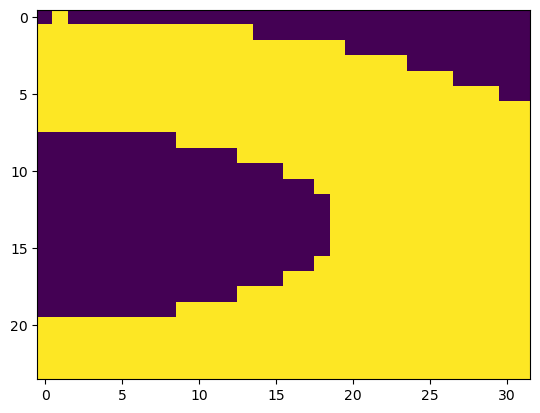

In [15]:
n=102200
dn=d[n]
plt.imshow(dn[0])

In [38]:
r,n,e,g,bx,by,lx,ly,g_op=get_nodes_ele(n=32,g=dn,show=False)
nodal=get_nodal_matrix(n=n,bx=bx,by=by,save=True)
elem=get_element_matrix(r=r,n=n,e=e,g=g,save=True)


In [41]:
import pyvista as pv
from pyvista import examples
saved_file = examples.download_file("dolfin_fine.xml")
print(saved_file)
dolfin = pv.read(saved_file)
dolfin

/home/cmu/.cache/pyvista_3/dolfin_fine.xml


UnstructuredGrid,Information
N Cells,5400
N Points,2868
X Bounds,"0.000e+00, 1.000e+00"
Y Bounds,"0.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


/home/cmu/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


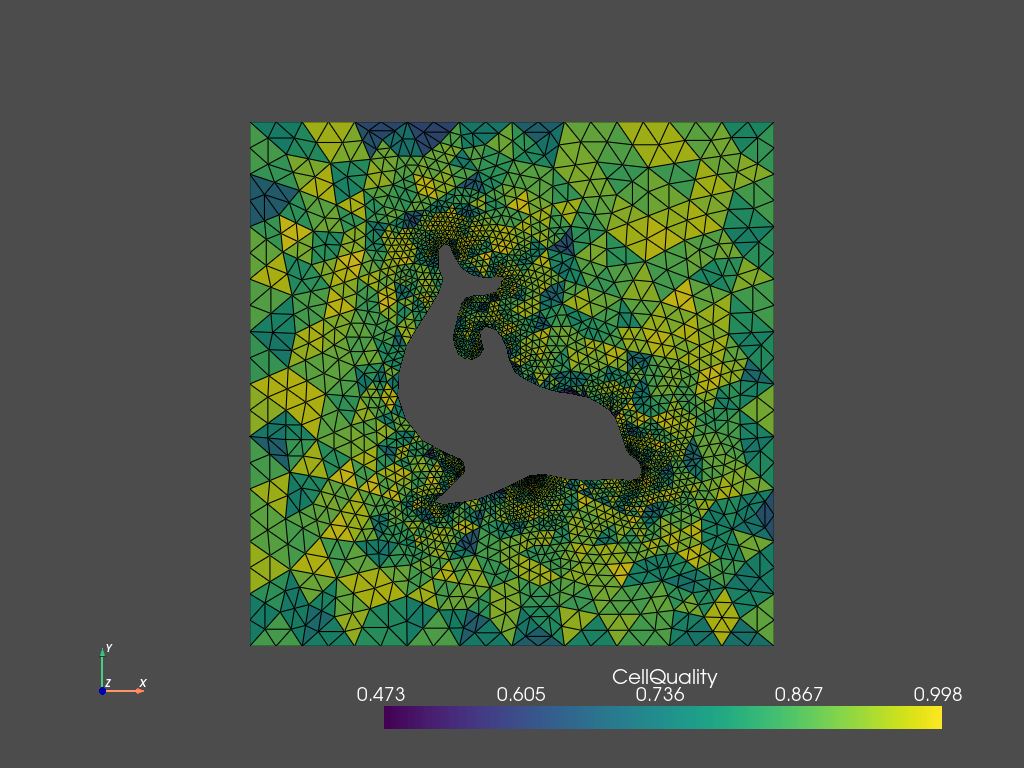

In [42]:
qual = dolfin.compute_cell_quality()
qual.plot(show_edges=True, cpos="xy")

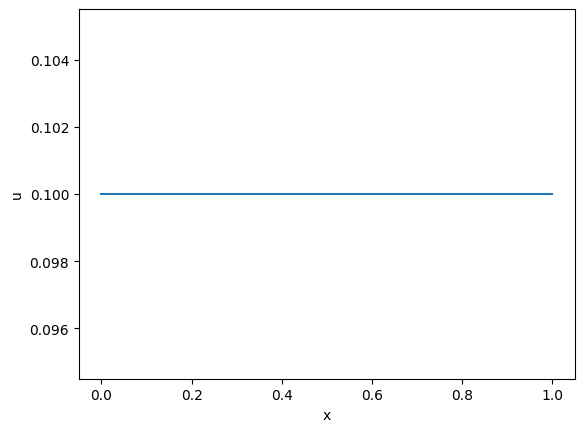

In [23]:

import numpy as np
from scipy.optimize import newton
import matplotlib.pyplot as plt
# Define your mesh
length = 1.0  # length of the rod
n_elements = 100  # number of elements in the mesh
dx = length / n_elements  # length of an element

# Material properties for the neo-Hookean model
mu = 1.0
lambda_ = 1.0

# Initial and boundary conditions
u = np.zeros(n_elements+1)  # displacement at each node, initialized to zero
u[-1] = 0.1  # apply a displacement at the right end of the rod

# Neo-Hookean strain energy density function
def strain_energy_density(F):
    J = F  # For 1D case, the deformation gradient F is simply the stretch ratio, which is 1 + strain
    C = F**2
    return 0.5 * mu * (C - 2) - mu * np.log(J) + lambda_/2 * (np.log(J))**2

# The derivative of the strain energy density function with respect to F
def strain_energy_density_derivative(F):
    J = F
    return mu * (F - 1/J) + lambda_ * np.log(J) / J

# Solve for the equilibrium state using the Newton-Raphson method
for i in range(n_elements, 0, -1):  # loop backwards from the right end to the left
    # solve for the displacement at node i-1
    def residual(u_i_minus_1):
        F = (u[i] - u_i_minus_1) / dx + 1
        return strain_energy_density_derivative(F) * dx

    u[i-1] = newton(residual, u[i])  # use the displacement at node i as the initial guess

# Plot the displacement field
plt.plot(np.linspace(0, length, n_elements+1), u)
plt.xlabel('x')
plt.ylabel('u')
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
E = 210e9  # Young's modulus in Pascals
ν = 0.3  # Poisson's ratio

μ = E / (2 * (1 + ν))  # Shear modulus
κ = E / (3 * (1 - 2 * ν))  # Bulk modulus

ε = np.array([[0.01, 0.005], [0.005, 0.01]])  # 2D strain tensor

I = np.eye(2)  # Identity matrix
S = 2 * μ * ε + (κ * np.trace(ε) - μ) * I  # 2nd Piola-Kirchhoff Stress


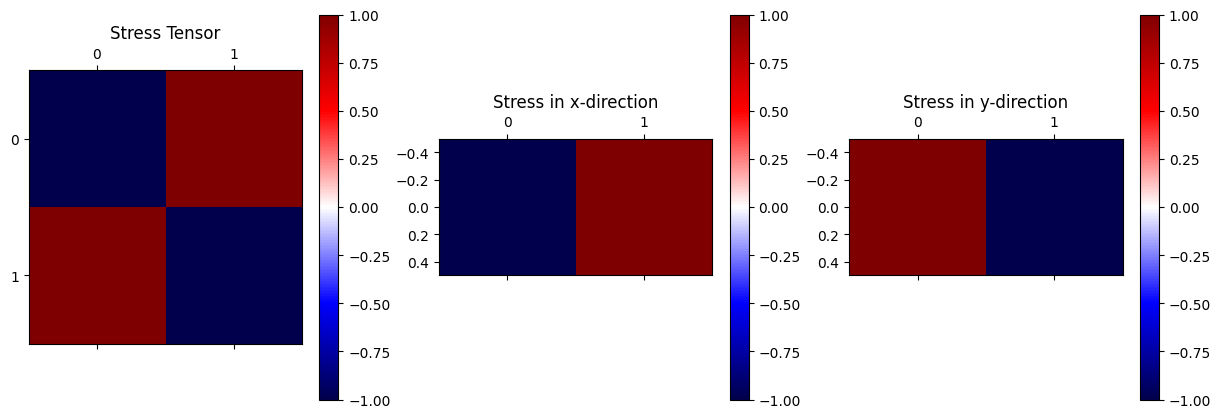

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cax0 = ax[0].matshow(S, vmin=-1, vmax=1, cmap='seismic')
fig.colorbar(cax0, ax=ax[0])
ax[0].set_title('Stress Tensor')
ax[1].matshow(S[0, :].reshape(1, -1), vmin=-1, vmax=1, cmap='seismic')
fig.colorbar(cax0, ax=ax[1])
ax[1].set_title('Stress in x-direction')
ax[2].matshow(S[1, :].reshape(1, -1), vmin=-1, vmax=1, cmap='seismic')
fig.colorbar(cax0, ax=ax[2])
ax[2].set_title('Stress in y-direction')
plt.show()


In [30]:
import numpy as np

from skfem import *
from skfem.helpers import grad, identity, ddot, det, transpose, inv, trace, mul

# note: rough mesh to make tests fast
mesh = MeshHex.init_tensor(
    np.linspace(0, 1, 10),
    np.linspace(-.1, .1, 3),
    np.linspace(-.1, .1, 3),
).with_boundaries({
    'left': lambda x: x[0] == 0.,
    'right': lambda x: x[0] == 1.,
})
element = ElementVector(ElementHex1())
basis = Basis(mesh, element, intorder=1)

mu, lmbda = 1., 2.

def deformation_gradient(w):
    dudX = grad(w["displacement"])
    F = dudX + identity(dudX)
    return F, inv(F)

@LinearForm
def L(v, w):
    F, iF = deformation_gradient(w)
    dF = grad(v)
    lnJ = np.log(det(F))
    return mu * ddot(F, dF) + (lmbda * lnJ - mu) * ddot(transpose(iF), dF)

@BilinearForm
def a(u, v, w):
    F, iF = deformation_gradient(w)
    DF = grad(u)
    dF = grad(v)
    dFiF = mul(dF, iF)
    DFiF = mul(DF, iF)
    tr_DFiF_dFiF = ddot(transpose(dFiF), DFiF)
    lnJ = np.log(det(F))
    return (mu * ddot(DF, dF) - (lmbda * lnJ - mu) * tr_DFiF_dFiF
            + lmbda * trace(dFiF) * trace(DFiF))

u  = basis.zeros()
du = basis.zeros()
uv = basis.interpolate(u)

dofs = basis.get_dofs('right')
dirichlet = basis.get_dofs({'right', 'left'})

f = L.assemble(basis, displacement=uv)
K = a.assemble(basis, displacement=uv)

right = -0.1
tol = 1e-10
nsteps = 7

for step in range(nsteps):
    for iteration in range(10):
        c = (step + 1.) / nsteps

        du_D = u.copy()
        x, y, z = basis.doflocs[:, dofs.nodal['u^1']]
        du_D[dofs.nodal['u^1']] = c * right - du_D[dofs.nodal['u^1']]
        du_D[dofs.nodal['u^2']] = (
            y * np.cos(c * np.pi) - z * np.sin(c * np.pi) - y
            - du_D[dofs.nodal['u^2']]
        )
        du_D[dofs.nodal['u^3']] = (
            y * np.sin(c * np.pi) + z * np.cos(c * np.pi) - z
            - du_D[dofs.nodal['u^3']]
        )

        du = solve(*condense(K, -f, x=du_D, D=dirichlet))
        norm_du = np.linalg.norm(du)
        u += du

        uv = basis.interpolate(u)

        f = L.assemble(basis, displacement=uv)
        K = a.assemble(basis, displacement=uv)

        print(1 + iteration, norm_du)

        if norm_du < tol:
            break



(mesh.translated(u[basis.nodal_dofs])
        .draw('vedo', point_data={'uy': u[basis.nodal_dofs[1]]})
        .show())

1 0.3013531513098912
2 0.04733915363011881
3 0.020381980217874195
4 0.005714616396672401
5 0.0002401461287627073
6 8.923406297008412e-07
7 6.097560237416379e-12
1 0.3026750470963954
2 0.04747474641275554
3 0.020058657296618983
4 0.00562172377920664
5 0.0002237320143240708
6 7.900124621825578e-07
7 4.59533302939562e-12
1 0.3040483779080429
2 0.04761937077927585
3 0.01973648692278184
4 0.005525011934935874
5 0.00020791792344457022
6 6.956237090003162e-07
7 3.4228431865269297e-12
1 0.30547792927542117
2 0.04777501405918577
3 0.019411825038367157
4 0.005424468996679347
5 0.00019265395562886124
6 6.089000601740984e-07
7 2.517587153366163e-12
1 0.306969023396345
2 0.04794389271776509
3 0.019080555356011657
4 0.005319949523719042
5 0.00017788670588438183
6 5.294968297776101e-07
7 1.82489214627092e-12
1 0.3085275834298479
2 0.04812848016780802
3 0.018738038572840707
4 0.0052111534296125665
5 0.00016356145831573725
6 4.5702840864543054e-07
7 1.3008738690189219e-12
1 0.31016020893226814
2 0.0483

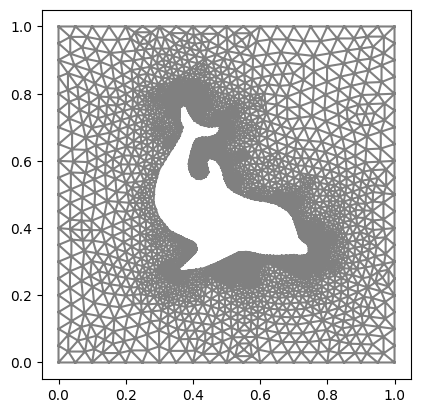

Computing mesh entities of dimension 1
Elapsed wall, usr, sys time: 0.00211939, 0.01, 0 (Compute entities dim = 1)
Computing sub domain markers for sub domain 1.
Requesting connectivity 1 - 2.
Requesting connectivity 2 - 1.
Computing mesh connectivity 1 - 2 from transpose.
Elapsed wall, usr, sys time: 0.000167633, 0, 0 (Compute connectivity 1-2)
Elapsed wall, usr, sys time: 6.48e-07, 0, 0 (Number distributed mesh entities)
Elapsed wall, usr, sys time: 0.000434667, 0, 0 (Init dofmap from UFC dofmap)
Determining node ownership for parallel dof map
Finished determining dof ownership for parallel dof map
Elapsed wall, usr, sys time: 2.208e-06, 0, 0 (SCOTCH: call SCOTCH_graphBuild)
Elapsed wall, usr, sys time: 0.000221363, 0, 0 (SCOTCH: call SCOTCH_graphOrder)
Elapsed wall, usr, sys time: 0.000284348, 0, 0 (Compute SCOTCH graph re-ordering)
Elapsed wall, usr, sys time: 0.00221339, 0, 0 (Init dofmap)
Elapsed wall, usr, sys time: 4.038e-06, 0, 0 (Apply (PETScVector))
Elapsed wall, usr, sys ti

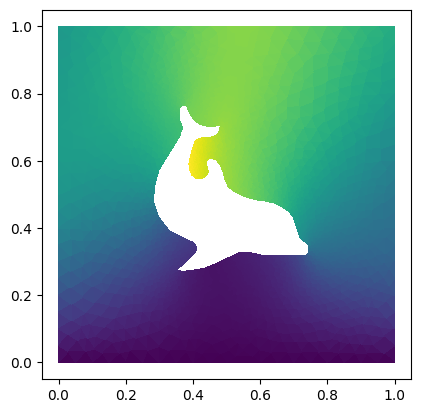

In [44]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import ufl

fe.set_log_level(13)

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Lame's constants
#lmbda = 1.25
#mu = 20

E = 20.0e6
mu = 0.5*E
rho_0 = 200.0

l_x, l_y = 1,1  # Domain dimensions
n_x, n_y = 64, 64  # Number of elements

# Load
g_int = 1.0e5
b_int = -10.0

# --------------------
# Geometry
# --------------------
mesh = fe.Mesh("dolfin_fine.xml")
# mesh = fe.RectangleMesh(fe.Point(0.0, 0), fe.Point(l_x, l_y), n_x, n_y)


fe.plot(mesh)
plt.show()

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
u = fe.Function(V)
g = fe.Constant((0.0, g_int))
b = fe.Constant((0.0, b_int))
N = fe.Constant((0.0, 1.0))

aa, bb, cc, dd, ee = 0.5*mu, 0.0, 0.0, mu, -1.5*mu

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
I = fe.Identity(2)
F = I + fe.grad(u)  # Deformation gradient
C = F.T*F  # Right Cauchy-Green tensor
J = fe.det(F)  # Determinant of deformation fradient

#psi = (aa*fe.tr(C) + bb*fe.tr(ufl.cofac(C)) + cc*J**2 - dd*fe.ln(J))*fe.dx - fe.dot(b, u)*fe.dx + fe.inner(f, u)*ds(1)
n = fe.dot(ufl.cofac(F), N)
surface_def = fe.sqrt(fe.inner(n, n))
psi = (aa*fe.inner(F, F) + ee - dd*fe.ln(J))*fe.dx - rho_0*J*fe.dot(b, u)*fe.dx + surface_def*fe.inner(g, u)*ds(1)

# --------------------
# Solver
# --------------------
Form = fe.derivative(psi, u, u_test)
Jac = fe.derivative(Form, u, u_tr)

problem = fe.NonlinearVariationalProblem(Form, u, bc, Jac)
solver = fe.NonlinearVariationalSolver(problem)
prm = solver.parameters
#prm["newton_solver"]["error_on_convergence"] = False
#fe.solve(Form == 0, u, bc, J=Jac, solver_parameters={"error_on_convergence": False})
solver.solve()




print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
print(u)
plt.show()

In [48]:
displacement_values = u.vector().get_local()
displacement_values.shape

(5736,)

/home/cmu/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


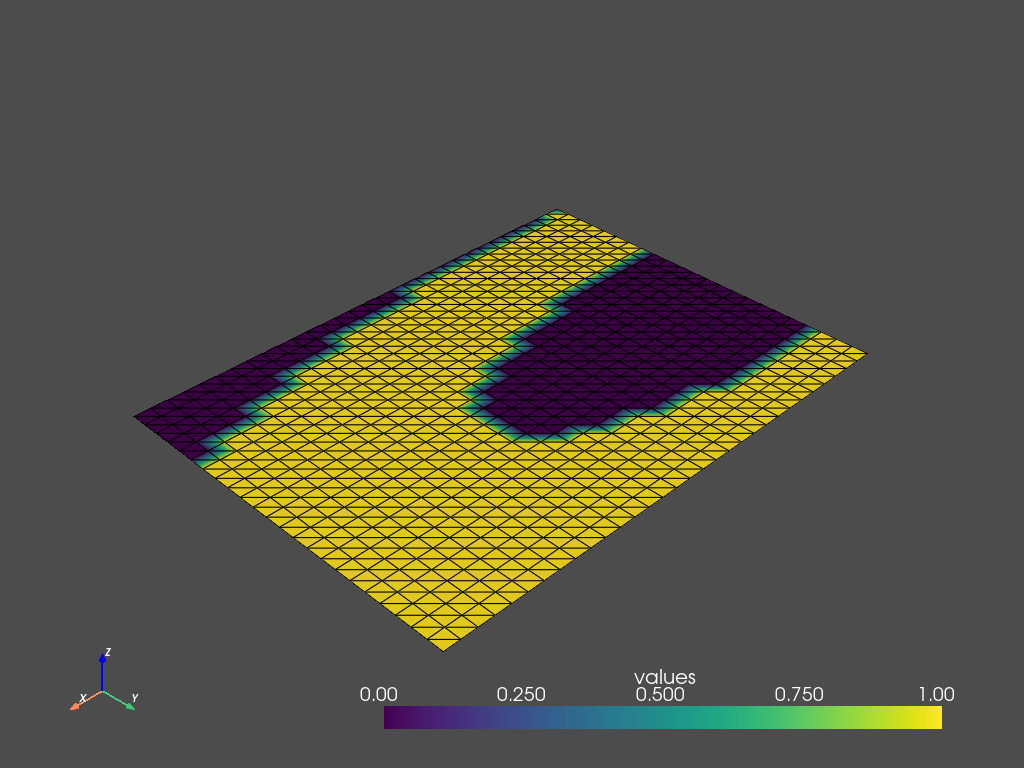

Only VTK 'UNSTRUCTURED_GRID, STRUCTURED_POINTS, STRUCTURED_GRID, RECTILINEAR_GRID' supported (not POLYDATA).


Error: Couldn't read file quad_mesh.vtk as vtk

SystemExit: 1

/home/cmu/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [62]:
import pyvista as pv
import numpy as np

# Assuming you have a 2D binary array like this:
binary_array = dn[0]

# Add a third dimension to the binary array
binary_image = binary_array[np.newaxis, :, :]

# Create an image data object
grid = pv.wrap(binary_image.T)

# Use threshold to create a mesh
mesh_0 = grid.threshold([0,0]).extract_geometry().triangulate()
mesh_1 = grid.threshold([1,1]).extract_geometry().triangulate()

# Combine the two meshes
mesh = mesh_0 + mesh_1
mesh=mesh.extract_geometry().triangulate()


# Visualize the mesh
mesh.plot(show_edges=True)

vtk_path = "quad_mesh.vtk"
mesh.save(vtk_path)

import meshio
mesh = meshio.read("quad_mesh.vtk")

In [56]:
m=pv.read("quad_mesh.vtk")

In [33]:
#open in meshio
import meshio
mesh = meshio.read("quad_mesh.vtk")

#save as xml
meshio.write("quad_mesh_2.xdmf", mesh)

Only VTK 'UNSTRUCTURED_GRID, STRUCTURED_POINTS, STRUCTURED_GRID, RECTILINEAR_GRID' supported (not POLYDATA).


Error: Couldn't read file quad_mesh.vtk as vtk

SystemExit: 1

/home/cmu/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/home/cmu/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


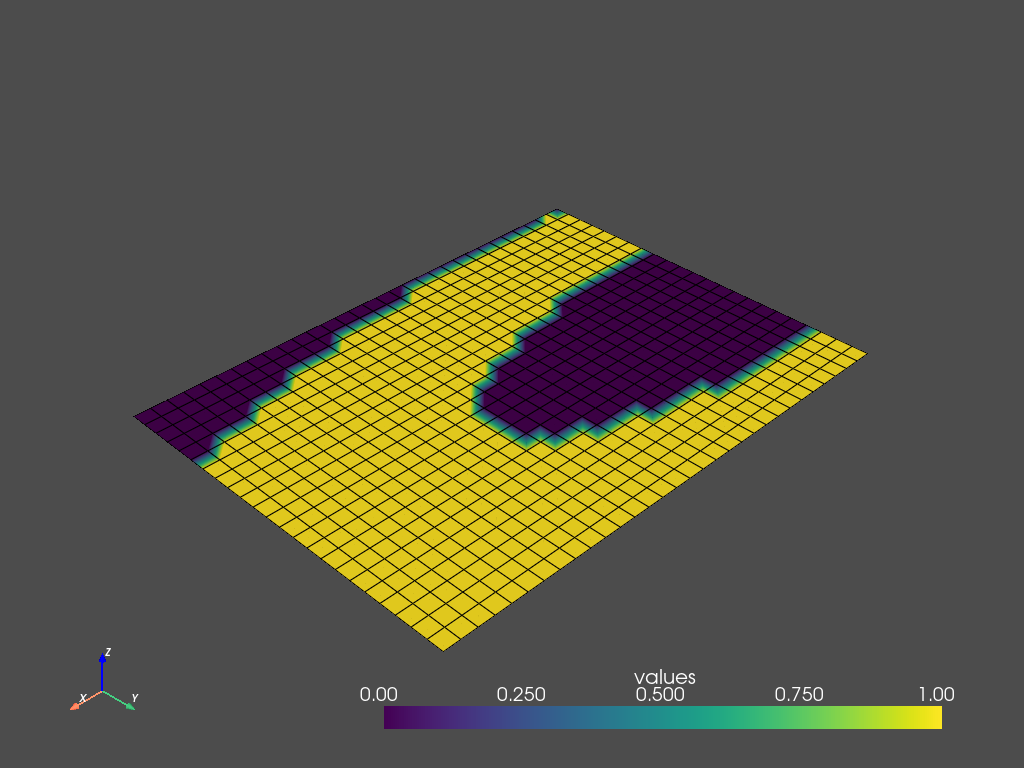

In [49]:
import pyvista as pv
import numpy as np

# Assuming you have a 2D binary array like this:
binary_array = dn[0]

# Add a third dimension to the binary array
binary_image = binary_array[np.newaxis, :, :]

# Create an image data object
grid = pv.wrap(binary_image.T)

# Use threshold to create a mesh
mesh_0 = grid.threshold([0,0])
mesh_1 = grid.threshold([1,1])

# Combine the two meshes
mesh = mesh_0 + mesh_1
mesh=mesh.extract_geometry()

# Convert to unstructured grid
ugrid = pv.UnstructuredGrid(mesh)

# Visualize the mesh
ugrid.plot(show_edges=True)

vtk_path = "quad_mesh.vtk"
ugrid.save(vtk_path)

import meshio
mesh = meshio.read("quad_mesh.vtk")
mesh.points=mesh.points[:,:2]
mesh.points

meshio.write("quad_mesh22.xdmf", mesh)


In [3]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import ufl

fe.set_log_level(13)

def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Density
rho = fe.Constant(200.0)

# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.0

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_z = -2.9575e5
b_z = -10.0
g = fe.Constant((0.0, g_z))
b = fe.Constant((0.0, b_z))

# Model type
model = "plane_strain"
if model == "plane_stress":
    lambda_ = 2*mu*lambda_/(lambda_+2*mu)

# --------------------
# Geometry
# --------------------



mesh = fe.Mesh("quad_mesh.xml")
# mesh = fe.RectangleMesh(fe.Point(0.0, 0), fe.Point(l_x, l_y), n_x, n_y)


# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))
fe.plot(mesh)


Ordering mesh.
Computing mesh entities of dimension 1
Elapsed wall, usr, sys time: 0.000288666, 0, 0 (Compute entities dim = 1)


TypeError: gca() got an unexpected keyword argument 'projection'

In [6]:
from dolfin import *
from fenics import *



In [8]:
f = XDMFFile('quad_mesh.xdmf')
mesh_l=Mesh()

In [9]:
f.read(mesh_l)

Ordering mesh.


In [10]:
(mesh_l)

Requesting connectivity 1 - 2.
Computing mesh entities of dimension 1
Elapsed wall, usr, sys time: 0.000277476, 0, 0 (Compute entities dim = 1)
Requesting connectivity 2 - 1.
Computing mesh connectivity 1 - 2 from transpose.
Elapsed wall, usr, sys time: 3.8804e-05, 0, 0 (Compute connectivity 1-2)


In [11]:
import numpy as np
import pyvista as pv

def create_mesh(inner_radius, thickness, height, z_res, c_res, r_res_pipe, r_res_fluid):
    # Create a pipe mesh using a structured grid using the specified mesh density:
    outer_radius = inner_radius + thickness

    # Create a list of radial divisions between the inner and outer radii:
    if r_res_pipe % 2 != 0:
        r_res_pipe = r_res_pipe + 1 # radial resolution must be even to accommodate array reshaping

    radial_divisions = np.linspace(inner_radius, outer_radius, r_res_pipe)

    grid = pv.CylinderStructured(
        radius=radial_divisions, height=height, theta_resolution=c_res, z_resolution=z_res
    )

    grid.points = grid.points
    original_mesh = pv.UnstructuredGrid(grid)

    pipe_mesh = original_mesh
    points = pipe_mesh.points.reshape(z_res, c_res, r_res_pipe * 3)
    points[:, c_res - 1, :] = points[:, 0, :]
    pipe_mesh.points = points.reshape(z_res * (c_res) * 2, int(r_res_pipe + r_res_pipe / 2))

    pipe_mesh.plot(color='grey', show_edges=True)

    # Create a fluid mesh using a structured grid based on the pipe dimensions:
    # Create a list of radial divisions between the inner and outer radii:
    if r_res_fluid % 2 != 0:
        r_res_fluid = r_res_fluid + 1 # radial resolution must be even to accommodate array reshaping

    radial_divisions = np.linspace(0.0, inner_radius, r_res_fluid)

    grid = pv.CylinderStructured(
        radius=radial_divisions, height=height, theta_resolution=c_res, z_resolution=z_res
    )

    grid.points = grid.points
    original_mesh = pv.UnstructuredGrid(grid)

    fluid_mesh = original_mesh
    points = fluid_mesh.points.reshape(z_res, c_res, r_res_fluid * 3)
    points[:, c_res - 1, :] = points[:, 0, :]
    fluid_mesh.points = points.reshape(z_res * (c_res) * 2, int(r_res_fluid + r_res_fluid / 2))

    fluid_mesh.plot(color='blue', show_edges=True)

    return pipe_mesh, fluid_mesh


p,e= create_mesh(inner_radius=0.5, thickness=0.1, height=1.0, z_res=10, c_res=10, r_res_pipe=10, r_res_fluid=10)


ValueError: cannot reshape array of size 3300 into shape (10,10,30)

In [18]:
import pyvista as pv
import numpy as np

# Define the size of your domain
domain_size = [10, 10]

# Define the number of cells for each material
n_material1 = [5, 5]
n_material2 = [5, 5]

# Create the grid for each material
grid_material1 = pv.UniformGrid()
grid_material1.dimensions = np.array(n_material1) + 1
grid_material1.origin = [0, 0, 0]  # The bottom left corner of the data set
grid_material1.spacing = [domain_size[0] / n_material1[0], domain_size[1] / n_material1[1], 1]  # These are the cell sizes along each axis

grid_material2 = pv.UniformGrid()
grid_material2.dimensions = np.array(n_material2) + 1
grid_material2.origin = [0, domain_size[1] / 2, 0]  # The bottom left corner of the data set
grid_material2.spacing = [domain_size[0] / n_material2[0], domain_size[1] / n_material2[1], 1]  # These are the cell sizes along each axis

# Assign a scalar field to each grid to represent the material type
grid_material1["Material"] = np.ones(grid_material1.n_cells) * 1
grid_material2["Material"] = np.ones(grid_material2.n_cells) * 2

# Combine the two meshes into a single one
combined_grid = grid_material1.copy()
combined_grid += grid_material2

# Save the combined grid to a .vtu file
combined_grid.save("combined_grid.vtu")


TypeError: no overloads of SetDimensions() take 2 arguments